In [1]:
ticker_name = 'AAPL'

In [2]:
# !python -m ipykernel install --user --name Py309 --display-name Py309

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import datetime, timedelta
import itertools
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanSquaredError,  MeanAbsoluteError, RootMeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.validation import check_is_fitted
from keras.initializers import glorot_uniform


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
print("Are there GPUs Available: ",tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Device Name: ",tf.test.gpu_device_name())
print("Is built with Cuda: ",tf.test.is_built_with_cuda())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Are there GPUs Available:  True
Num GPUs Available:  1
GPUs Device Name:  /device:GPU:0
Is built with Cuda:  True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13730796586282914631
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6277824512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2747444943108499478
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
def create_arima_features (ticker_name, year_start= 2000, num_prev_clos = 7, num_int_diff = 3, visualize = False):

    df = pd.read_csv('G:/My Drive/Ingegneria/Data Science GD/stock_market_data/nasdaq/csv/' + ticker_name +'.csv') 
    df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
    df = df[df['Date'].dt.year >= year_start]
    
    # df['CloseID0'] = df['Adjusted Close'].copy()
    
    for days_bef in range(1, num_prev_clos):
        
    #autoregression    
    
        df['CloseAR'+str(days_bef)] = [df['Adjusted Close'].iloc[j - days_bef] 
                                     if j >= days_bef else None
                                     for j in range(len(df))]
   
    #simple moving average  
    
        if days_bef > 1:

            df['CloseSMA'+str(days_bef)] = [np.mean([df['Adjusted Close'].iloc[j - days_bef + i] 
                                                    for i in range(days_bef)])
                                           if j >= days_bef else None
                                           for j in range(len(df))]
            
    #integrated differencing

    for i in range(num_int_diff):
                   df['CloseID'+str(i+2)] = [df['CloseAR'+str(i+1)].iloc[j] - df['CloseAR'+str(i+1)].iloc[j-1]
                     if j > 0 else None
                     for j in range(len(df))]
        
        
    #rolling means of the 'num_prev_close' open, high, low, volume (function that could be used also in the previous formulas)
    
    df['VolumeSMA'+str(num_prev_clos)] = df['Volume'].shift(1).rolling(window=num_prev_clos).mean()
    df['OpenSMA'+str(num_prev_clos)] = df['Open'].shift(1).rolling(window=num_prev_clos).mean()
    df['HighSMA'+str(num_prev_clos)] = df['High'].shift(1).rolling(window=num_prev_clos).mean()
    df['LowSMA'+str(num_prev_clos)] = df['Low'].shift(1).rolling(window=num_prev_clos).mean()
    
    
    #optional visualizations
    
    if visualize:
        plt.plot(df['Date'],df['Adjusted Close'])
        plt.xlabel("Date")
        plt.ylabel("Close")
        plt.title(ticker_name + " Stock Prices")
        plt.show()
    
    df.drop(columns=[ 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
        
    return df.iloc[max(num_prev_clos,num_int_diff):,:] #remove first rows


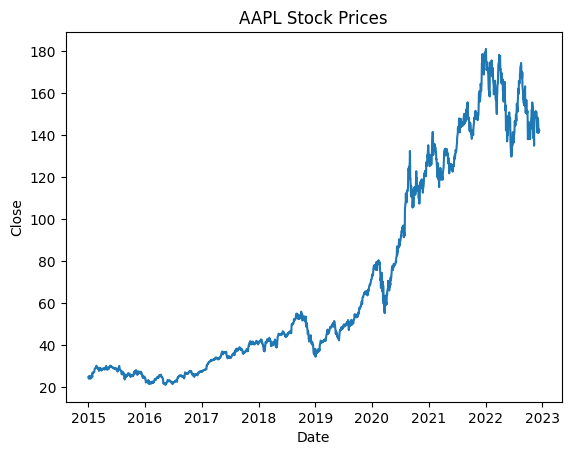

In [5]:
df = create_arima_features(ticker_name = ticker_name, year_start= 2015, visualize = True, num_prev_clos = 7, num_int_diff = 3)

In [6]:
X = df # 'Adjusted Close' and 'date' fields dropped afterwards
y= df['Adjusted Close']

X.head(10)

,Date,Adjusted Close,CloseAR1,CloseAR2,CloseSMA2,CloseAR3,CloseSMA3,CloseAR4,CloseSMA4,CloseAR5,CloseSMA5,CloseAR6,CloseSMA6,CloseID2,CloseID3,CloseID4,VolumeSMA7,OpenSMA7,HighSMA7,LowSMA7
8596,2015-01-13,24.803495,24.585209,25.206305,24.895757,25.179298,24.990271,24.247646,24.804615,23.912348,24.626161,23.910093,24.506817,-0.621096,0.027006,0.931652,2.206331e+08,27.425714,27.633929,26.850000
8597,2015-01-14,24.708975,24.803495,24.585209,24.694352,25.206305,24.865003,25.179298,24.943577,24.247646,24.804391,23.912348,24.655717,0.218287,-0.621096,0.027006,2.285687e+08,27.427143,27.682500,26.905714
8598,2015-01-15,24.038364,24.708975,24.803495,24.756235,24.585209,24.699226,25.206305,24.825996,25.179298,24.896656,24.247646,24.788488,-0.094521,0.218287,-0.621096,2.198093e+08,27.453929,27.748214,27.016071
8599,2015-01-16,23.851589,24.038364,24.708975,24.373670,24.803495,24.516945,24.585209,24.534011,25.206305,24.668470,25.179298,24.753608,-0.670610,-0.094521,0.218287,2.165047e+08,27.577500,27.842143,27.088572
8600,2015-01-20,24.465933,23.851589,24.038364,23.944977,24.708975,24.199643,24.803495,24.350606,24.585209,24.397527,25.206305,24.532323,-0.186775,-0.670610,-0.094521,2.384518e+08,27.571429,27.820000,27.035000
8601,2015-01-21,24.652708,24.465933,23.851589,24.158761,24.038364,24.118629,24.708975,24.266215,24.803495,24.373671,24.585209,24.408928,0.614344,-0.186775,-0.670610,2.330434e+08,27.521785,27.706429,26.956429
8602,2015-01-22,25.294065,24.652708,24.465933,24.559320,23.851589,24.323410,24.038364,24.252149,24.708975,24.343514,24.803495,24.420177,0.186775,0.614344,-0.186775,2.301157e+08,27.388928,27.628214,26.887143
8603,2015-01-23,25.424587,25.294065,24.652708,24.973387,24.465933,24.804235,23.851589,24.566074,24.038364,24.460532,24.708975,24.501939,0.641357,0.186775,0.614344,2.324846e+08,27.305357,27.622500,26.920000
8604,2015-01-26,25.451597,25.424587,25.294065,25.359326,24.652708,25.123787,24.465933,24.959323,23.851589,24.737777,24.038364,24.621208,0.130522,0.641357,0.186775,2.206977e+08,27.336429,27.656428,27.013571
8605,2015-01-27,24.560446,25.451597,25.424587,25.438092,25.294065,25.390083,24.652708,25.205739,24.465933,25.057778,23.851589,24.856747,0.027010,0.130522,0.641357,2.245025e+08,27.504286,27.794643,27.167143


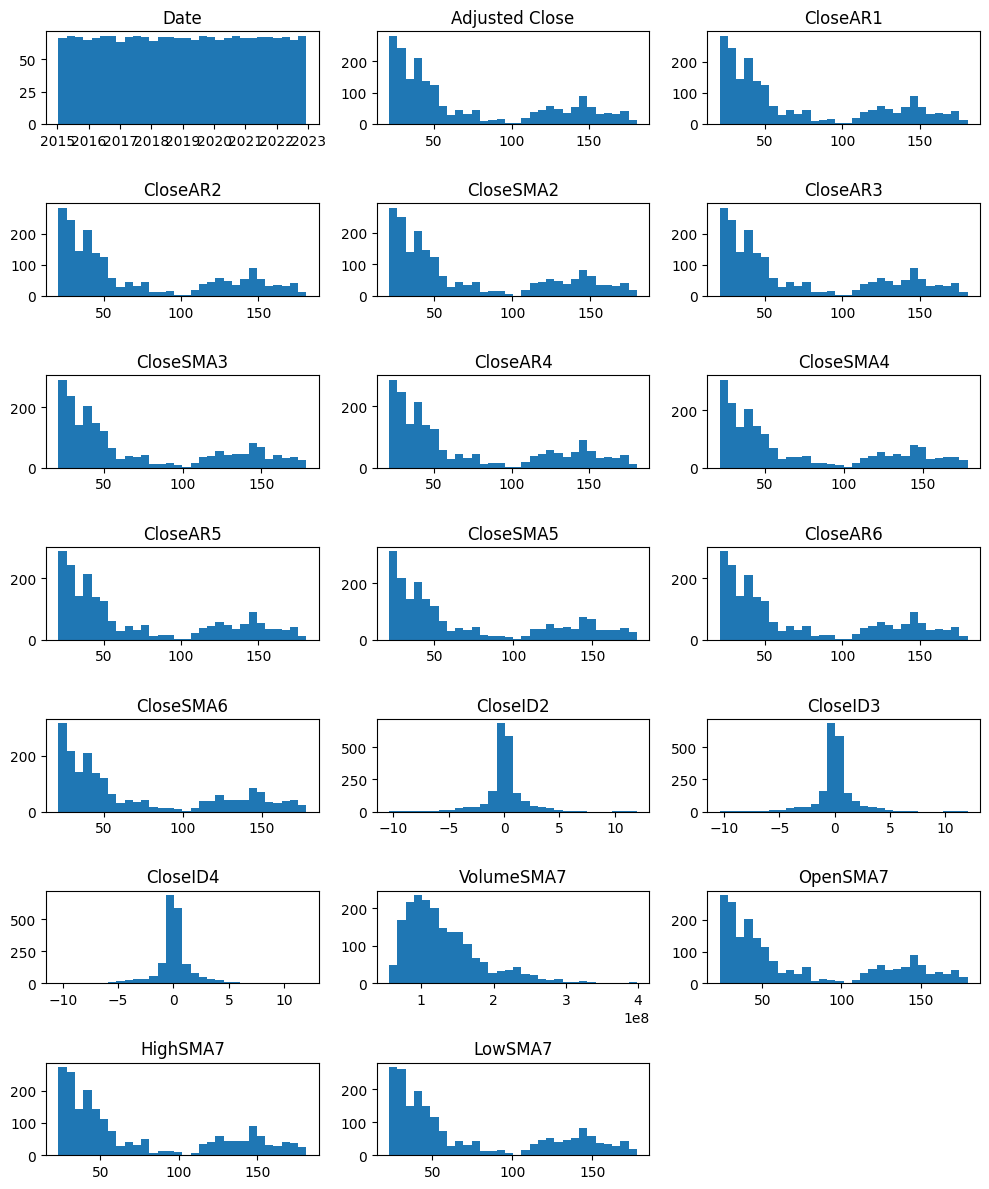

In [7]:
plt.figure(figsize=(10, 12))
for index, feature in enumerate(X, 1):  #starting index from 1, for plotting
    plt.subplot(X.shape[1] // 3 + 1, 3, index)
    plt.hist(X[feature], bins = 30)
    plt.title(feature)
    plt.tight_layout()

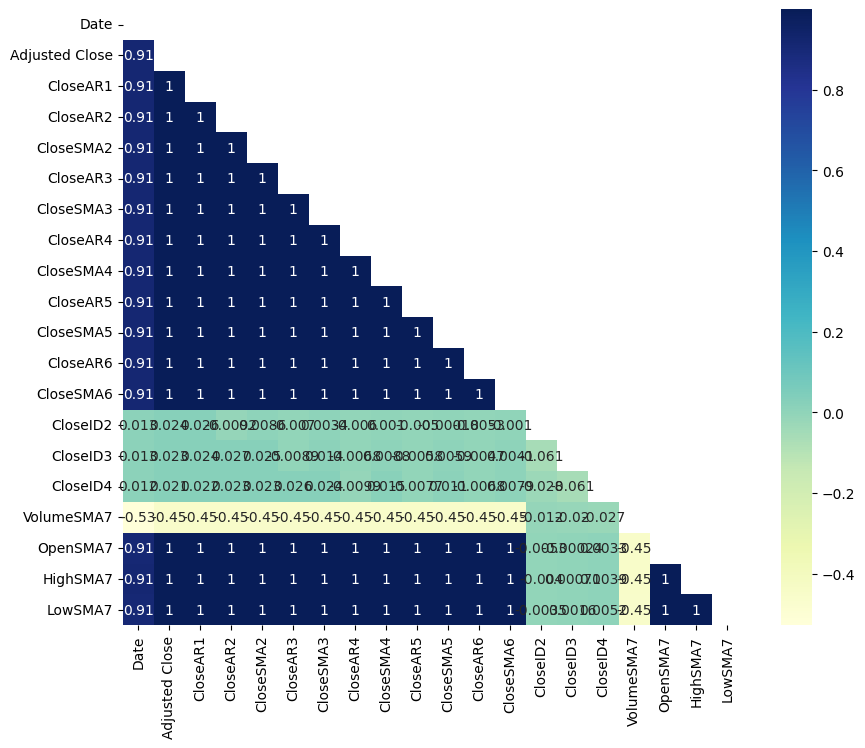

In [8]:
#check features correlation

plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", mask=mask)

# Show the plot
plt.show()

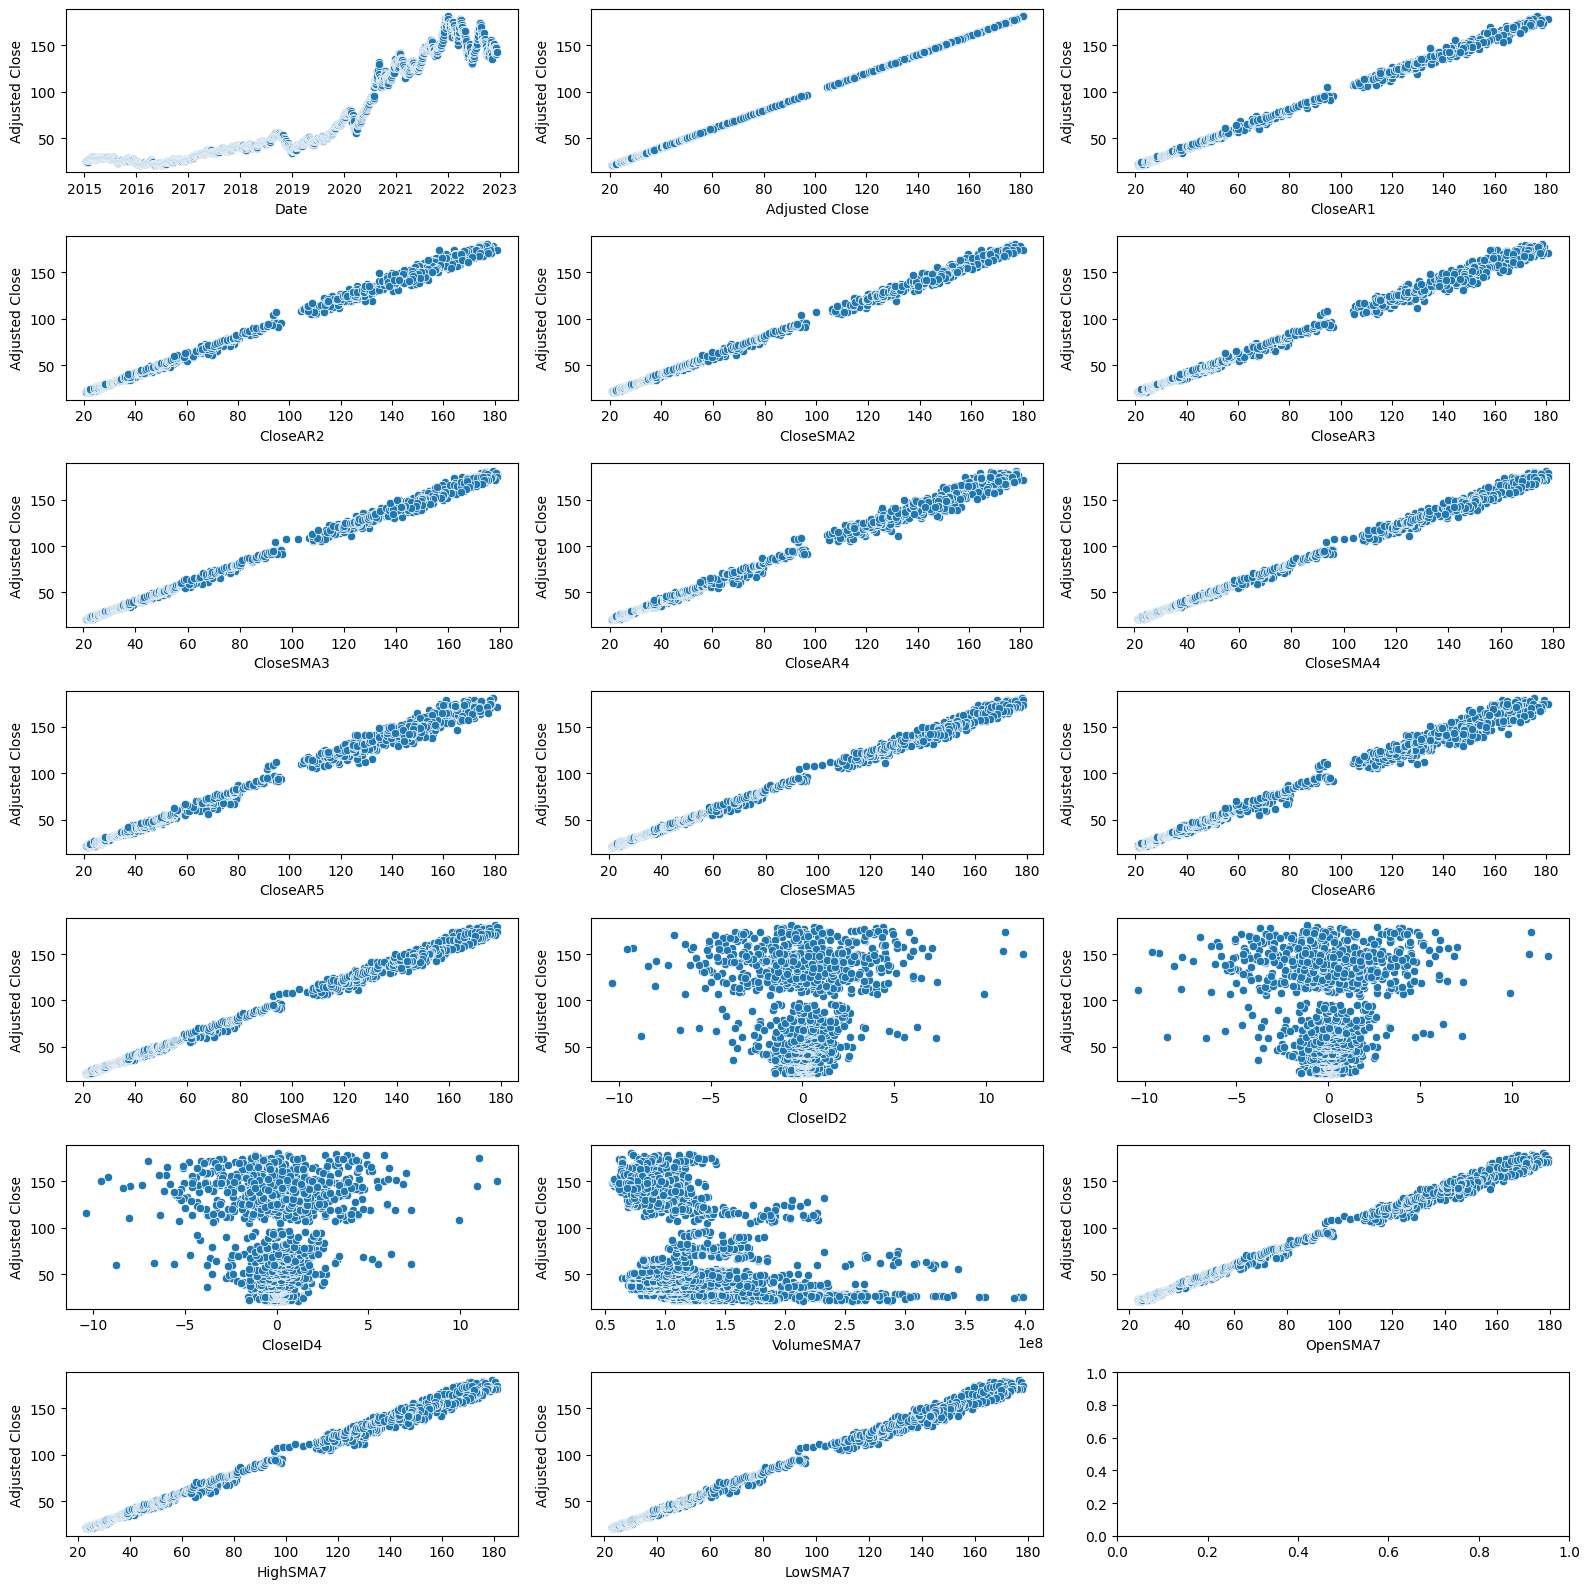

In [9]:
#correlation between features and label

fig, axes = plt.subplots(nrows=X.shape[1] // 3 + 1, ncols=3, figsize=(16, 16))
for i, feature in enumerate(X.columns):
    row = i // 3
    col = i % 3
    sns.scatterplot(x=feature, y='Adjusted Close', data=df, ax=axes[row, col])
plt.tight_layout()
plt.show()


In [10]:
X_Train, X_Test, y_Train, y_Test  = train_test_split(X, y, test_size=0.1, shuffle=False)

In [11]:
# scaler = MinMaxScaler(feature_range=(0, 1))
features_scaler = StandardScaler()
label_scaler = StandardScaler()

X_Train_scaled = features_scaler.fit_transform(X_Train.drop(['Date','Adjusted Close'], axis=1))
X_Test_scaled = features_scaler.transform(X_Test.drop(['Date','Adjusted Close'], axis=1))
y_Train_scaled = label_scaler.fit_transform(y_Train.values.reshape(-1, 1))


In [12]:
X_Train_scaled_resh = X_Train_scaled.reshape((X_Train_scaled.shape[0], 1, X_Train_scaled.shape[1]))
X_Test_scaled_resh = X_Test_scaled.reshape((X_Test_scaled.shape[0], 1, X_Test_scaled.shape[1]))

print(X_Train.shape)
print(X_Train_scaled.shape)
print(X_Train_scaled_resh.shape)

print(X_Test.shape)
print(X_Test_scaled.shape)
print(X_Test_scaled_resh.shape)

(1794, 20)
(1794, 18)
(1794, 1, 18)
(200, 20)
(200, 18)
(200, 1, 18)


*******************************
Fit with y_Train_scaled
******************************

In [71]:
model1 = keras.models.Sequential()
model1.add(keras.layers.LSTM(units=2048,
                            return_sequences=True, # Whether to return the last output in the output sequence, or the full sequence
                            input_shape=(1, X_Train_scaled.shape[1]), # input_shape = (numb of timesteps: 1, number of features)
                            kernel_initializer=glorot_uniform(),
                            recurrent_initializer=glorot_uniform(),
                            bias_initializer='zeros'))

model1.add(keras.layers.LSTM(units=1024, return_sequences=True))
model1.add(keras.layers.Dropout(0.0001))
model1.add(keras.layers.LSTM(units=512))

# flatten the output from the LSTM layer into a 1D vector
#necessary because the output shape of the LSTM layer is (batch_size, timesteps, units), 
#and we want to pass a 2D input of shape (batch_size, n_feat) to the next layer.
model1.add(keras.layers.Flatten()) 

model1.add(keras.layers.Dense(2048))
model1.add(keras.layers.Dropout(0.0001))
model1.add(keras.layers.Dense(1))
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 2048)           16932864  
                                                                 
 lstm_19 (LSTM)              (None, 1, 1024)           12587008  
                                                                 
 dropout_8 (Dropout)         (None, 1, 1024)           0         
                                                                 
 lstm_20 (LSTM)              (None, 512)               3147776   
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 2048)              1050624   
                                                                 
 dropout_9 (Dropout)         (None, 2048)             

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(monitor='loss', patience=10)

optimizer = Adam(lr=0.0001)

model1.compile(optimizer=optimizer,
               metrics=[MeanSquaredError(), MeanAbsoluteError(), RootMeanSquaredError()],
               loss='mean_squared_error')
history = model1.fit(X_Train_scaled_resh,
                    y_Train_scaled,
                    epochs=100,
                   callbacks=[early_stopping_monitor])

Epoch 1/100
57/57 [==============================] - 5s 26ms/step - loss: 0.2590 - mean_squared_error: 0.2590 - mean_absolute_error: 0.3078 - root_mean_squared_error: 0.5089
Epoch 2/100
57/57 [==============================] - 1s 25ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0470
Epoch 3/100
57/57 [==============================] - 1s 25ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0230 - root_mean_squared_error: 0.0365
Epoch 4/100
57/57 [==============================] - 1s 25ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0361
Epoch 5/100
57/57 [==============================] - 1s 25ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0360
Epoch 6/100
57/57 [==============================] - 1s 25ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_erro

In [73]:
# predict the testing data
y_Pred = model1.predict(X_Test_scaled_resh)
y_Pred_invers = label_scaler.inverse_transform(y_Pred)
y_Pred_invers_arr = np.array(list(itertools.chain(*y_Pred_invers)))

# Reshape y_Test to 1D array
y_Test_arr = y_Test.values 
 
# evaluation metrics
mse = np.mean(((y_Pred_invers_arr - y_Test_arr) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

for i in range (7):
    print(i)
    print('y_Pred:', y_Pred_invers_arr[i])
    print('y_Test:', y_Test_arr[i])
    print('diff:', y_Pred_invers_arr[i] - y_Test_arr[i])

7/7 [==============================] - 1s 28ms/step
MSE 14.861883821724915
RMSE 3.8551113890165243
0
y_Pred: 162.32161
y_Test: 164.37635803222656
diff: -2.05474853515625
1
y_Pred: 164.53444
y_Test: 162.4650115966797
diff: 2.069427490234375
2
y_Pred: 161.45378
y_Test: 165.8098907470703
diff: -4.356109619140625
3
y_Pred: 163.36235
y_Test: 165.4813690185547
diff: -2.1190185546875
4
y_Pred: 163.00342
y_Test: 162.4351348876953
diff: 0.5682830810546875
5
y_Pred: 161.7087
y_Test: 158.5825958251953
diff: 3.1260986328125
6
y_Pred: 157.51611
y_Test: 156.73094177246094
diff: 0.7851715087890625


In [16]:
# def r2_score(y_true, y_pred):
#     SS_res = K.sum(K.square(y_true - y_pred))
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return 1 - SS_res / (SS_tot + K.epsilon())

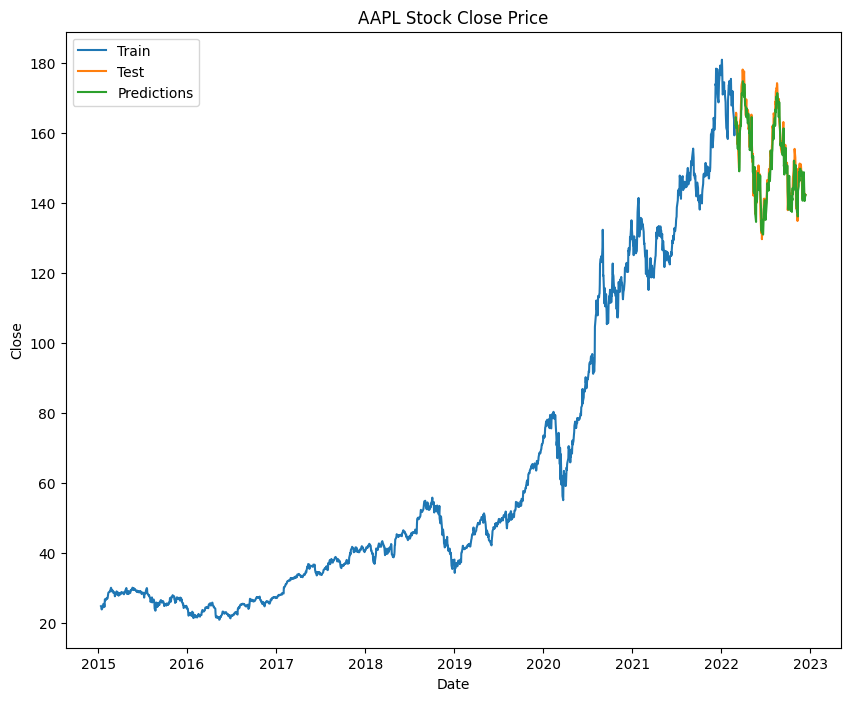

In [74]:
df_viz_test = X_Test[['Date','Adjusted Close']].assign(Predicted_Close = y_Pred_invers_arr).rename(columns={'Adjusted Close': 'Actual_Close'})
df_viz_train = X_Train[['Date','Adjusted Close']].rename(columns={'Adjusted Close': 'Actual_Close'})

plt.figure(figsize=(10, 8))
plt.plot(df_viz_train['Date'], df_viz_train['Actual_Close'])
plt.plot(df_viz_test['Date'], df_viz_test[['Actual_Close', 'Predicted_Close']])
plt.title(ticker_name+' Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Train', 'Test', 'Predictions'])

In [75]:
pd.set_option('display.max_rows', None)

df_viz_train['Predicted_Close'] = None
last_row_df_Train = pd.DataFrame(df_viz_train.iloc[-1]).transpose()
df_predictions = pd.concat([last_row_df_Train, df_viz_test], axis=0).reset_index()
df_predictions['Previous_Close'] = df_predictions['Actual_Close'].shift(1)
df_predictions = df_predictions[1::]
df_predictions['Pred_Increased'] = df_predictions.apply(lambda x: 1 if x['Predicted_Close'] > x['Previous_Close'] else 0, axis=1)
df_predictions['Act_Increased'] = df_predictions.apply(lambda x: 1 if x['Actual_Close'] > x['Previous_Close'] else 0, axis=1)
df_predictions['Pred_variat_perc'] = (df_predictions['Predicted_Close'] - df_predictions['Previous_Close'])/df_predictions['Previous_Close']*100
df_predictions['Act_variat_perc'] = (df_predictions['Actual_Close'] - df_predictions['Previous_Close'])/df_predictions['Previous_Close']*100
df_predictions['Act_variat_perc'] = (df_predictions['Actual_Close'] - df_predictions['Previous_Close'])/df_predictions['Previous_Close']*100
df_predictions.head()



,index,Date,Actual_Close,Predicted_Close,Previous_Close,Pred_Increased,Act_Increased,Pred_variat_perc,Act_variat_perc
1,10390,2022-02-28,164.376358,162.321609,164.10759,0,1,-1.088298,0.163776
2,10391,2022-03-01,162.465012,164.534439,164.376358,1,0,0.09617,-1.162787
3,10392,2022-03-02,165.809891,161.453781,162.465012,0,1,-0.62243,2.05883
4,10393,2022-03-03,165.481369,163.362350,165.809891,0,0,-1.476112,-0.198132
5,10394,2022-03-04,162.435135,163.003418,165.481369,0,0,-1.49742,-1.840832


Text(0.5, 1.0, 'Confusion Matrix')

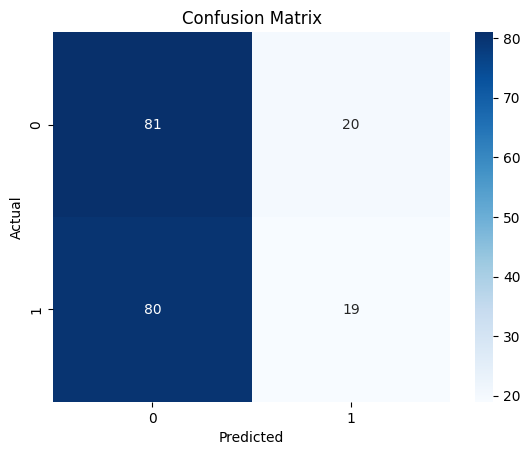

In [76]:
# Create confusion matrix
cm = confusion_matrix(df_predictions['Act_Increased'], df_predictions['Pred_Increased'])

# Visualize confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [77]:
report = classification_report(df_predictions['Act_Increased'], df_predictions['Pred_Increased'])

print(report)

              precision    recall  f1-score   support

           0       0.50      0.80      0.62       101
           1       0.49      0.19      0.28        99

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.45       200
weighted avg       0.50      0.50      0.45       200



In [78]:

def Calc_Return(init_invest, max_desired_invest = np.inf,  risk_factor = 1, commiss_perc = 0.01):
    
    day_amount_inv = []
    day_perc_return = []    
    day_short_comm = []
    day_end_amount = []
        
    for i in range(len(df_predictions)):
        
        # percentage invested proportional to the confidence of the model prediction
        perc_invest = df_predictions['Pred_variat_perc'].iloc[i] 
        #percentage of gain or loss 
        perc_gain_loss = df_predictions['Act_variat_perc'].iloc[i] 
        
        daily_amount_owned = init_invest if i == 0 else day_end_amount[i - 1]

        max_amount_invest = min(max_desired_invest, daily_amount_owned)
        
        amount_invest = min(daily_amount_owned * np.abs(perc_invest)/100 * risk_factor, max_amount_invest)
        # could be eventually modified, if we want to allow to invest more than the amount owned, during short trading
        day_amount_inv.append(amount_invest)
        
        if commiss_perc <= 0: # no short positions allowed
            daily_return = amount_invest * perc_gain_loss/100 * perc_invest if np.sign(perc_invest) == 1 else 0
        else:
            daily_return = amount_invest * np.abs(perc_gain_loss)/100 * np.sign(perc_invest) * np.sign(perc_gain_loss)
            # positive if sign(perc_invest)==sign(perc_gain_loss), negative otherwise
        
        day_perc_return.append(daily_return)
        
        short_commiss = amount_invest * commiss_perc if np.sign(perc_invest) == -1 else 0
        day_short_comm.append(short_commiss)
        
        day_end_amount.append(daily_amount_owned + daily_return - short_commiss)

    return day_amount_inv, day_perc_return, day_short_comm, day_end_amount



In [79]:
DayAmountInv, DayPercReturn, Short_Commiss, DayEndAmount = Calc_Return(init_invest = 10000, risk_factor = 10, commiss_perc = 0)

df_predictions['DayAmountInv'] = DayAmountInv
df_predictions['Short_Commiss'] = Short_Commiss
df_predictions['DayPercReturn'] = DayPercReturn
df_predictions['DayEndAmount'] = DayEndAmount
df_predictions

,index,Date,Actual_Close,Predicted_Close,Previous_Close,Pred_Increased,Act_Increased,Pred_variat_perc,Act_variat_perc,DayAmountInv,Short_Commiss,DayPercReturn,DayEndAmount
1,10390,2022-02-28,164.376358,162.321609,164.10759,0,1,-1.088298,0.163776,1088.298370,0.0,0.000000,10000.000000
2,10391,2022-03-01,162.465012,164.534439,164.376358,1,0,0.09617,-1.162787,96.170189,0.0,-0.107543,9999.892457
3,10392,2022-03-02,165.809891,161.453781,162.465012,0,1,-0.62243,2.05883,622.422997,0.0,0.000000,9999.892457
4,10393,2022-03-03,165.481369,163.362350,165.809891,0,0,-1.476112,-0.198132,1476.096481,0.0,0.000000,9999.892457
5,10394,2022-03-04,162.435135,163.003418,165.481369,0,0,-1.49742,-1.840832,1497.403856,0.0,0.000000,9999.892457
6,10395,2022-03-07,158.582596,161.708694,162.435135,0,0,-0.447219,-2.37174,447.213971,0.0,0.000000,9999.892457
7,10396,2022-03-08,156.730942,157.516113,158.582596,0,0,-0.672509,-1.167628,672.501966,0.0,0.000000,9999.892457
8,10397,2022-03-09,162.216141,155.485260,156.730942,0,1,-0.79479,3.499755,794.781396,0.0,0.000000,9999.892457
9,10398,2022-03-10,157.806107,159.828766,162.216141,0,0,-1.471725,-2.718616,1471.708791,0.0,0.000000,9999.892457
10,10399,2022-03-11,154.033157,156.411972,157.806107,0,0,-0.883448,-2.390877,883.438264,0.0,0.000000,9999.892457


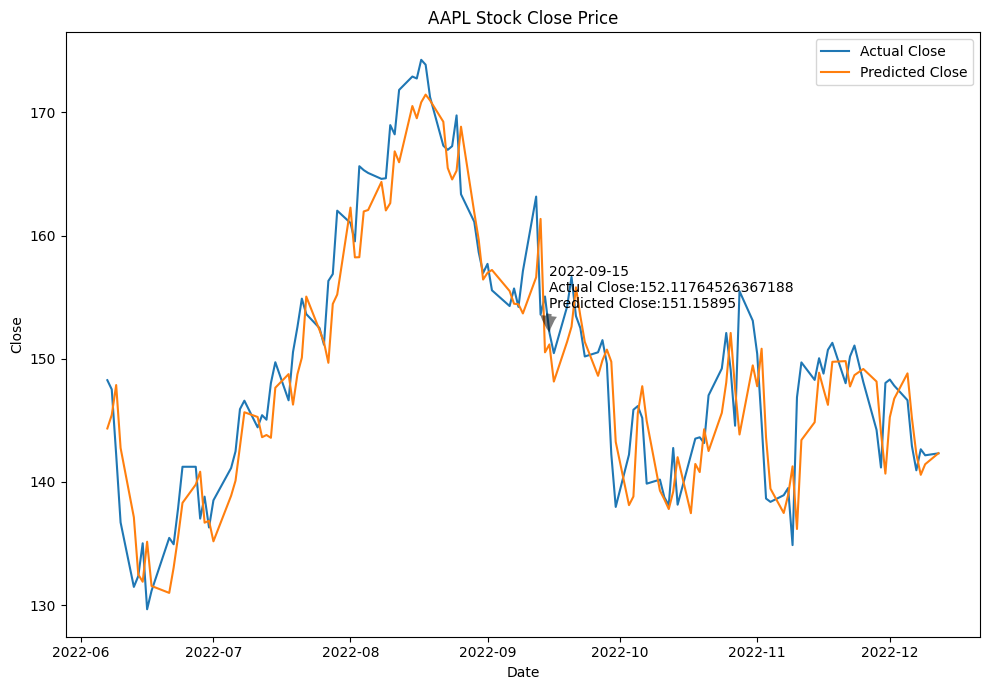

In [80]:
date_to_annotate = datetime(2022, 9, 15)

start_date = date_to_annotate - timedelta(days=100)
end_date = date_to_annotate + timedelta(days=100)

df_pred_filt = df_predictions[(df_predictions['Date'] >= start_date) & (df_predictions['Date'] <= end_date)]

plt.figure(figsize=(10, 7))

# Filter the DataFrame based on the date range
plt.plot(df_pred_filt['Date'], 
         df_pred_filt[['Actual_Close', 'Predicted_Close']])
plt.title(ticker_name + ' Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Actual Close', 'Predicted Close'])

# Find the index of the date to annotate
date_index = df_predictions[df_predictions['Date'] == date_to_annotate].index[0]
act_close = df_predictions[df_predictions['Date'] == date_to_annotate]['Actual_Close']
pred_close = df_predictions[df_predictions['Date'] == date_to_annotate]['Predicted_Close']

# Annotate the date
plt.annotate(str(date_to_annotate.date())+'\nActual Close:'+str(act_close.values[0])+'\nPredicted Close:'+str(pred_close.values[0]), 
             xy=(date_to_annotate, df_predictions['Actual_Close'][date_index]), 
             xytext=(date_to_annotate, df_predictions['Actual_Close'][date_index] + 2),
             arrowprops=dict(facecolor='black', linewidth=0.001, alpha = 0.5, connectionstyle="arc3,rad=0.1"))

plt.tight_layout()
plt.show()


In [24]:
df_pred_filt

,index,Date,Actual_Close,Predicted_Close,Previous_Close,Pred_Increased,Act_Increased,Pred_variat_perc,Act_variat_perc,DayAmountInv,Short_Commiss,DayPercReturn,DayEndAmount
70,10459,2022-06-07,148.257797,147.580170,145.695602,1,1,1.293496,1.758594,1141.223840,0.0,25.959824,8848.743617
71,10460,2022-06-08,147.510071,151.867294,148.257797,1,0,2.434609,-0.504342,2154.322724,0.0,-26.452402,8822.291216
72,10461,2022-06-09,142.206253,150.530914,147.510071,1,0,2.04789,-3.595563,1806.707907,0.0,-133.033624,8689.257592
73,10462,2022-06-10,136.713013,143.181519,142.206253,1,0,0.685811,-3.862868,595.918463,0.0,-15.787048,8673.470544
74,10463,2022-06-13,131.478958,139.377792,136.713013,1,0,1.949178,-3.828498,1690.613604,0.0,-126.160733,8547.309811
75,10464,2022-06-14,132.356277,136.304428,131.478958,1,1,3.670146,0.66727,3136.987653,0.0,76.824125,8624.133936
76,10465,2022-06-15,135.018158,137.177917,132.356277,1,1,3.642925,2.011148,3141.707373,0.0,230.175969,8854.309904
77,10466,2022-06-16,129.66449,140.335251,135.018158,1,0,3.938058,-3.965147,3486.878284,0.0,-544.475235,8309.834669
78,10467,2022-06-17,131.159927,131.395279,129.66449,1,1,1.334821,1.153313,1109.214404,0.0,17.075989,8326.910658
79,10468,2022-06-21,135.456818,133.443802,131.159927,1,1,1.74129,3.276069,1449.956507,0.0,82.714022,8409.624680


In [25]:
X_Test[(X_Test.Date >= start_date) & (X_Test.Date <= end_date)]

,Date,Adjusted Close,CloseAR1,CloseAR2,CloseSMA2,CloseAR3,CloseSMA3,CloseAR4,CloseSMA4,CloseAR5,CloseSMA5,CloseAR6,CloseSMA6,CloseID2,CloseID3,CloseID4,VolumeSMA7,OpenSMA7,HighSMA7,LowSMA7
10459,2022-06-07,148.257797,145.695602,144.937912,145.316757,150.750183,147.127899,148.257797,147.410374,148.387390,147.605777,149.184952,147.868973,0.757690,-5.812271,2.492386,8.458597e+07,146.215714,149.175716,144.734283
10460,2022-06-08,147.510071,148.257797,145.695602,146.976700,144.937912,146.297104,150.750183,147.410374,148.257797,147.579858,148.387390,147.714447,2.562195,0.757690,-5.812271,8.132979e+07,147.210000,149.841431,145.728570
10461,2022-06-09,142.206253,147.510071,148.257797,147.883934,145.695602,147.154490,144.937912,146.600346,150.750183,147.430313,148.257797,147.568227,-0.747726,2.562195,0.757690,7.604003e+07,147.665715,149.868574,146.042858
10462,2022-06-10,136.713013,142.206253,147.510071,144.858162,148.257797,145.991374,145.695602,145.917431,144.937912,145.721527,150.750183,146.559636,-5.303818,-0.747726,2.562195,7.114783e+07,147.381428,149.481430,145.427144
10463,2022-06-13,131.478958,136.713013,142.206253,139.459633,147.510071,142.143112,148.257797,143.671783,145.695602,144.076547,144.937912,144.220108,-5.493240,-5.303818,-0.747726,7.359801e+07,146.007143,147.912857,143.910001
10464,2022-06-14,132.356277,131.478958,136.713013,134.095985,142.206253,136.799408,147.510071,139.477074,148.257797,141.233218,145.695602,141.976949,-5.234055,-5.493240,-5.303818,8.072073e+07,143.869999,145.617142,141.707145
10465,2022-06-15,135.018158,132.356277,131.478958,131.917618,136.713013,133.516083,142.206253,135.688625,147.510071,138.052914,148.257797,139.753728,0.877319,-5.234055,-5.493240,8.017987e+07,141.902858,143.605713,139.852857
10466,2022-06-16,129.664490,135.018158,132.356277,133.687218,131.478958,132.951131,136.713013,133.891602,142.206253,135.554532,147.510071,137.547122,2.661880,0.877319,-5.234055,8.302767e+07,140.082857,142.001426,138.032859
10467,2022-06-17,131.159927,129.664490,135.018158,132.341324,132.356277,132.346308,131.478958,132.129471,136.713013,133.046179,142.206253,134.572858,-5.353668,2.661880,0.877319,8.878706e+07,138.330000,139.628568,135.881428
10468,2022-06-21,135.456818,131.159927,129.664490,130.412209,135.018158,131.947525,132.356277,132.049713,131.478958,131.935562,136.713013,132.731804,1.495438,-5.353668,2.661880,1.002971e+08,135.685715,137.229998,133.359998
